Chin-I Tang, Huang Qian

OPTI 556 computational Imaging

Final Project: NLoS imaging


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import numpy as np

def g(f,d,lam): 
    # fresnel propagation
    # f: propagated image
    # d: propagation distance (pixels)
    # lam: wavelength (pixels)
    zPad = int(4*np.abs(d*lam))
    inF = np.zeros(np.add(f.shape,[zPad,zPad])).astype('complex128')
    inF[int(inF.shape[0]/2-f.shape[0]/2):int(inF.shape[0]/2+f.shape[0]/2),int(inF.shape[0]/2-f.shape[0]/2):int(inF.shape[0]/2+f.shape[0]/2)] = f
    urange = np.linspace(-lam/2,lam/2,inF.shape[0])
    u,v = np.meshgrid(urange,urange)
    g = np.fft.ifft2(np.fft.fft2(inF)*np.fft.fftshift(np.exp(1j *2* np.pi *(d/lam)*np.sqrt( 1 - u**2 - v**2))))
    return g

The graph below is our system schematic diagram.
We create a Gaussian point source on the wall, and the distance from the wall to the target is d1=1028mm. The light will be reflected back to the wall and form a pattern, which would be captured by camera. The propagation distance to the wall is d2=1066.24mm  

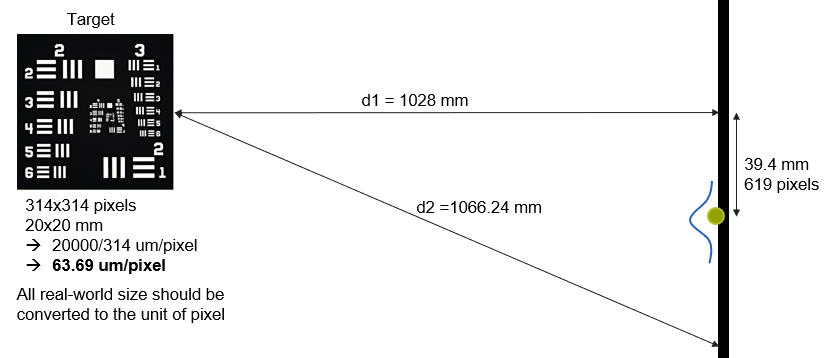

We can convert those real-world units into pixels. For intance, the real-world target size is 20mmx20mm, and we set it to 314x314 pixels, so we  get 20000/314 um/pixel. Use this parameter to convert length (um) to pixel.

In [ ]:
target_size = 20000 # um
target_pixel = 314 # pixel
umperpix = target_size / target_pixel # used to change all real-world length into pixels
lam = 0.532 / umperpix # wavelength in pixels
d1 = 1028 * 1000. / umperpix # distance from point source to object
d2 = 1066.24 * 1000. / umperpix # distance from target to wall
w0 = 1 / umperpix # focus spot FWHM on the wall
shift_from_target = int(39.4*1000 / umperpix) # point source is not perpendicular to the object
urange = np.arange(shift_from_target-500, shift_from_target+500)
vrange = np.arange(-500, 500)
UU,VV = np.meshgrid(urange,vrange)

Propagate the gaussian spot on the wall to the distance d1. 9 different gaussian spot on the wall are simulated, as shown below.

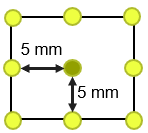

In [ ]:
spot_shift_x = np.array([-5000, 0, 5000]) / umperpix # shift 5mm interval for x direction 
spot_shift_y = np.array([-5000, 0, 5000]) / umperpix # shift 5mm interval for y direction
gaussian_spots = np.zeros((len(spot_shift_y), len(spot_shift_x), 1000, 1000)).astype(np.complex128)

for idx, i in  enumerate(spot_shift_x):
    for idy, j in enumerate(spot_shift_y):
        gaussian_spots[idy,idx,:,:] = np.exp(-1j*np.pi/4)*np.exp(1j*2*np.pi*d1/lam)*np.exp(-np.pi*((UU+i)**2+(VV+j)**2)/(w0**2+1j*lam*d1))/(w0**2+1j*lam*d1) # store the iluminations

gaussian_spots.shape

(3, 3, 1000, 1000)

Show the illuminations on the target.

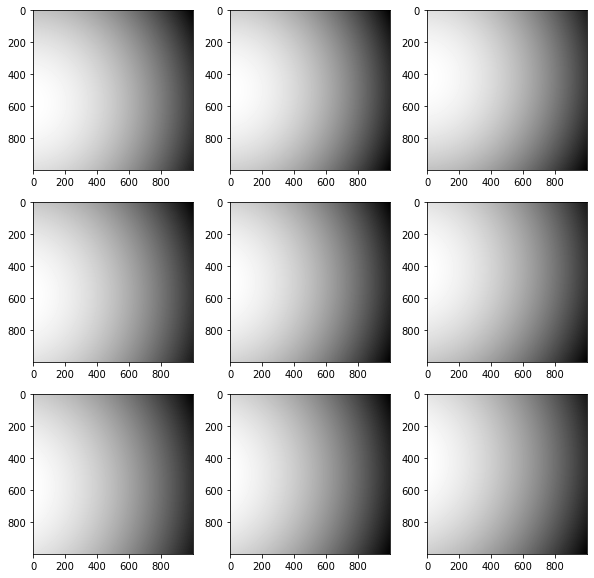

In [ ]:
m = 1
plt.figure(figsize=(10,10))
for i in range(len(spot_shift_x)):
    for j in range(len(spot_shift_y)):
      plt.subplot(3,3,m)
      plt.imshow(np.abs(gaussian_spots[j,i,:,:]),cmap='gray')
      m = m + 1

Load the target (314x314), and pad to (1000,1000).
Calculate the target illuminated by the gaussian spot by target times illumination.

(3, 3, 1000, 1000)

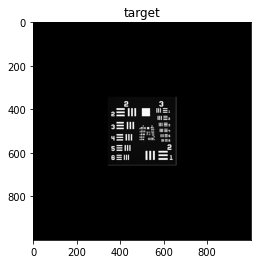

In [ ]:
mask = cv2.imread('test.jpg', 0)
mask = cv2.resize(mask, (314,314))
h_pad, w_pad = 343, 343
mask = np.pad(mask, ((h_pad,h_pad), (w_pad,w_pad))).astype(np.complex128)
fields_at_target = np.zeros_like(gaussian_spots)

for i in range(len(spot_shift_x)):
    for j in range(len(spot_shift_y)):
        a = gaussian_spots[j,i,:,:] * mask # gaussian beam propagate to the object
        a[:h_pad] = 0.
        a[-h_pad:] = 0.
        a[:,:w_pad] = 0.
        a[:,-w_pad:] = 0.
        fields_at_target[j,i,:,:] = a

plt.title('target')
plt.imshow(np.abs(mask), cmap='gray')
fields_at_target.shape

Plot the illuminated pattern for different gaussian spot location.

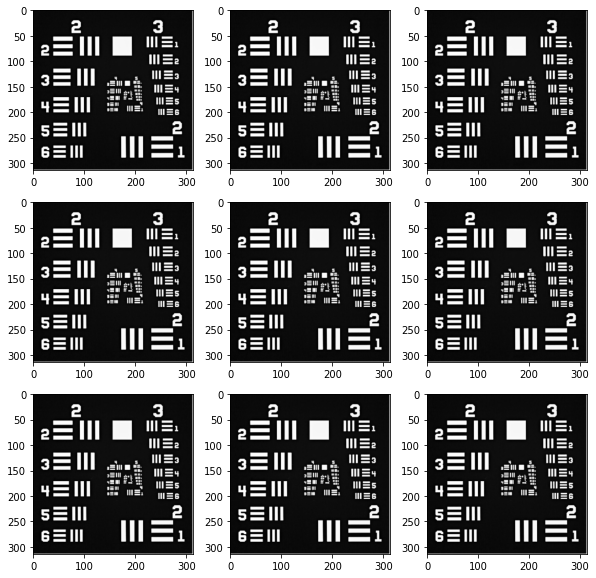

In [ ]:
m = 1
plt.figure(figsize=(10,10))
for i in range(len(spot_shift_x)):
    for j in range(len(spot_shift_y)):
      plt.subplot(3,3,m)
      plt.imshow(np.abs(fields_at_target[j,i,:,:])[343:343+314,343:343+314],cmap='gray')
      m = m + 1

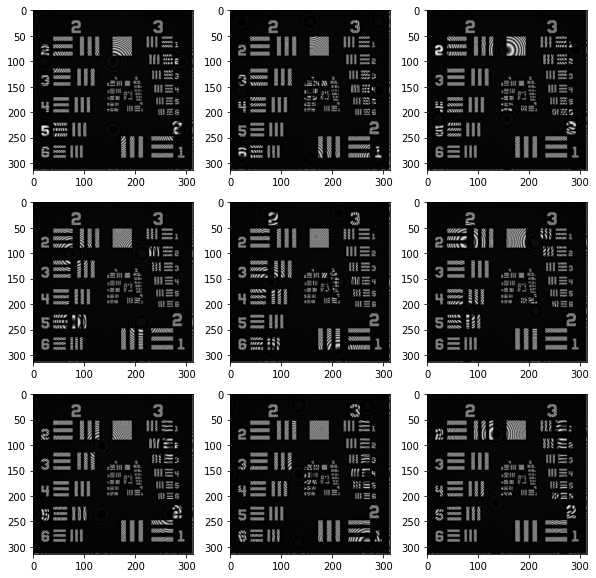

In [ ]:
m = 1
plt.figure(figsize=(10,10))
for i in range(len(spot_shift_x)):
    for j in range(len(spot_shift_y)):
      plt.subplot(3,3,m)
      plt.imshow((np.abs(fields_at_target[j,i,:,:])*np.abs(np.angle(fields_at_target[j,i,:,:])))[343:343+314,343:343+314],cmap='gray')
      m = m + 1

Propagated (fresnel propagation) those illuminated target back to the wall (d2=1066.24mm)

In [ ]:
back2wall = np.zeros((len(spot_shift_y),len(spot_shift_x),1559,1559)).astype(np.complex128)
measurements = np.zeros_like(back2wall)
for i in range(len(spot_shift_x)):
    for j in range(len(spot_shift_y)):
        back2wall[j,i,:,:] = g(fields_at_target[j,i,:,:], d2, lam) # back propagate to the wall
        measurements[j,i,:,:] = np.abs(back2wall[j,i,:,:]).astype(np.complex128)

back2wall.shape

(3, 3, 1559, 1559)

Show the pattern on the wall (measurements)

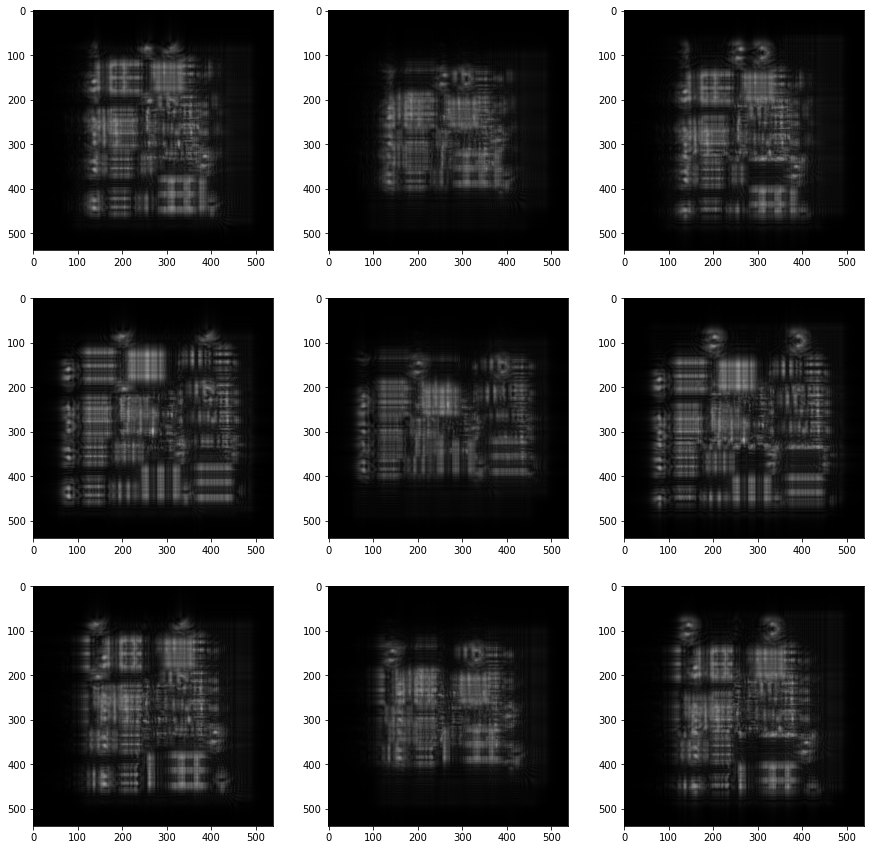

In [ ]:
plt.figure(figsize=(15,15))
k = 1
for i in range(len(spot_shift_x)):
    for j in range(len(spot_shift_y)):
        plt.subplot(len(spot_shift_x),len(spot_shift_y),k)
        plt.imshow(np.abs(measurements[j,i,:,:])[510:-510, 510:-510], cmap='gray')
        k = k+1

Choose a measurement and retrieval. (initialize)

In [ ]:
retriv_target = g(np.abs(measurements[len(spot_shift_y)//2,len(spot_shift_x)//2,:,:]).astype(np.complex128), -d2, lam)[558:-560,558:-560]
target_est = retriv_target
power = np.sqrt(np.sum(np.abs(measurements)**2)/(len(spot_shift_x) * len(spot_shift_y)))
target_est = power * target_est / np.sqrt(np.sum(np.abs(target_est)**2))
measuremets_retriv = np.zeros_like(measurements)

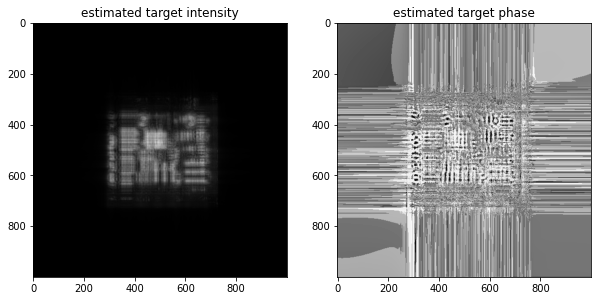

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('estimated target intensity')
plt.imshow(np.abs(target_est), cmap='gray')
plt.subplot(1,2,2)
plt.title('estimated target phase')
plt.imshow(np.angle(target_est), cmap='gray')

Phase retrieval

1. Fresnel propagate the field to the wall, we get Amplitude and Phase.
2. We already have the measuremnets (intensity), retain the phase obtained from 1.
3. Retrieve the target by back propagating (-d2) to the target plane (retriv_target).
4. Combine this result (retriv_target) with the accumulated result (target_est). 
5. Go to 1.


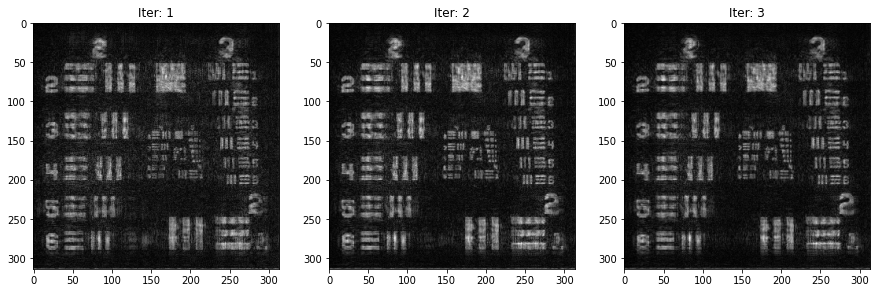

In [ ]:
plt.figure(figsize=(15,5))
n = 3
for iter in range(n):
    for i in range(len(spot_shift_x)):
        for j in range(len(spot_shift_y)):
            field_at_target = gaussian_spots[j,i,:,:] * target_est
            field_at_target[:h_pad] = 0
            field_at_target[-h_pad:] = 0
            field_at_target[:,:w_pad] = 0
            field_at_target[:,-w_pad:] = 0
            
            measuremets_retriv[j,i,:,:] = measurements[j,i,:,:] * np.exp(1j*np.angle(g(field_at_target, d2, lam)))
            retriv_target = g(measuremets_retriv[j,i,:,:], -d2, lam)[558:-560,558:-560]
            target_est = 0.9*target_est + 0.1*retriv_target/gaussian_spots[j,i,:,:]
            target_est = power * target_est / np.sqrt(np.sum(np.abs(target_est)**2))
    plt.subplot(1,3,iter+1)
    plt.title('Iter: '+ str(iter+1))
    plt.imshow(np.abs(target_est)[343:343+314,343:343+314], cmap='gray')